In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Topic: EX2 - Turbofan RUL Prediction
**Task**: Predict the remaining useful life (RUL) of turbofan engines based on given sensor data (time series data). It is a regression problem.
**Data**: Turbofan engine degradation simulation data (NASA) - [Link](https://data.nasa.gov/dataset/Turbofan-Engine-Degradation-Simulation-Data-Set/vrks-gjie). See also in the topic [introduction notebook](https://github.com/nina-prog/damage-propagation-modeling/blob/2fb8c1a1102a48d7abbf04e4031807790a913a99/notebooks/Turbofan%20remaining%20useful%20life%20Prediction.ipynb).

**Subtasks**:
1. Perform a deep **exploratory data analysis (EDA)** on the given data.
2. Implement a more efficient **sliding window method** for time series data analysis. -> 🎯 **Focus on this task**
3. Apply **traditional machine learning methods** (SOTA) to predict the remaining useful life. Includes data preparation, feature extraction, feature selection, model selection, and model parameter optimization.
4. Create **neural network models** to predict the remaining useful life. Includes different architectures like Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), or Attention Models. Note: You can search for SOTA research papers and reproduce current state-of-the-art models.


# Imports + Settings

In [3]:
# third-party libraries
import pandas as pd
import numpy as np
import os

import time
from tqdm.notebook import tqdm

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# source code
from src.utils import load_data, load_config
from src.logger import setup_logger

In [5]:
# settings
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')

In [27]:
logger = setup_logger(__name__, level='DEBUG')

In [6]:
np.random.seed(42)

# Paths

In [7]:
# Make sure to execute this cell only once for one kernel session, before running any other cell below.
os.chdir("../") # set working directory to root of project
os.getcwd() # check current working directory

'D:\\Uni\\Programming\\Python\\damage-propagation-modeling'

In [8]:
PATH_TO_CONFIG = "configs/config.yaml"

# Load Config + Data

In [9]:
config = load_config(PATH_TO_CONFIG) # config is dict

In [10]:
train_data, test_data = load_data(config_path=PATH_TO_CONFIG, dataset_num=1, raw=False)

2024-05-12 23:24:03 [src.utils:58] [INFO] >>>> Loading data set 1...
2024-05-12 23:24:03 [src.utils:100] [INFO] >>>> Loaded feature and target data for dataset 1.
2024-05-12 23:24:03 [src.utils:101] [INFO] >>>> Train Data: (20631, 27)
2024-05-12 23:24:03 [src.utils:102] [INFO] >>>> Test Data: (13096, 27)


# Subtask 1: Exploratory Data Analysis & Feature Engineering

[TEMPLATE]

Findings:
* Interpretation of plots
* or other key take aways from previous code

In [11]:
# [TEMPLATE] - save processed data (as pickle)
df = pd.DataFrame()
timestamp = time.strftime("%Y%m%d-%H%M%S")
df.to_pickle(f"{config['paths']['processed_data_dir']}ex2_topic_{timestamp}.pkl")

In [12]:
# [TEMPLATE] - save data predictions (as csv)
df = pd.DataFrame()
timestamp = time.strftime("%Y%m%d-%H%M%S")
df.to_csv(f"{config['paths']['prediction_dir']}ex2_topic_{timestamp}.csv", sep=',', decimal='.')

In [13]:
# [TEMPLATE] - save plot results (as png)
fig = plt.figure(figsize=(9, 6))
timestamp = time.strftime("%Y%m%d-%H%M%S")
fig.savefig(f"{config['paths']['plot_dir']}ex2_topic_{timestamp}.png")

<Figure size 900x600 with 0 Axes>

In [164]:
#print("Komplette Übersicht", train_data)
print("shape: ", train_data.shape)
print("Spalten",  train_data.columns)
print("Info", train_data.info())
print("NaN: ", train_data.isna().sum()) 
#logger.info() später nochmal ausprobieren, gerade format errors

shape:  (20631, 27)
Spalten Index(['UnitNumber', 'Cycle', 'Operation Setting 1', 'Operation Setting 2',
       'Operation Setting 3', 'Sensor Measure 1', 'Sensor Measure 2',
       'Sensor Measure 3', 'Sensor Measure 4', 'Sensor Measure 5',
       'Sensor Measure 6', 'Sensor Measure 7', 'Sensor Measure 8',
       'Sensor Measure 9', 'Sensor Measure 10', 'Sensor Measure 11',
       'Sensor Measure 12', 'Sensor Measure 13', 'Sensor Measure 14',
       'Sensor Measure 15', 'Sensor Measure 16', 'Sensor Measure 17',
       'Sensor Measure 18', 'Sensor Measure 19', 'Sensor Measure 20',
       'Sensor Measure 21', 'RUL'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UnitNumber           20631 non-null  int64  
 1   Cycle                20631 non-null  int64  
 2   Operation Setting 1  20631 non-null  floa

In [61]:
print(train_data.describe())
print(train_data.head())

         UnitNumber         Cycle  Operation Setting 1  Operation Setting 2  \
count  20631.000000  20631.000000         20631.000000         20631.000000   
mean      51.506568    108.807862            -0.000009             0.000002   
std       29.227633     68.880990             0.002187             0.000293   
min        1.000000      1.000000            -0.008700            -0.000600   
25%       26.000000     52.000000            -0.001500            -0.000200   
50%       52.000000    104.000000             0.000000             0.000000   
75%       77.000000    156.000000             0.001500             0.000300   
max      100.000000    362.000000             0.008700             0.000600   

       Operation Setting 3  Sensor Measure 1  Sensor Measure 2  \
count              20631.0          20631.00      20631.000000   
mean                 100.0            518.67        642.680934   
std                    0.0              0.00          0.500053   
min                  100

In [99]:
#fig, axes = plt.subplots(nrows=3, ncols=9, figsize=(36, 18))
#axes.hist(data=df_sm)
#for i,col in enumerate(train_data.columns):
#    sns.histplot(data=train_data[col], ax=axes[i // 9 , i%9], common_norm=False)
#plt.show()

In [157]:
# Split data by ID 
min_id = train_data["UnitNumber"].values.min()
max_id = train_data["UnitNumber"].values.max()

sensor_measure_columns_names =["Sensor Measure "+str(i) for i in range(1,22)]

# create a list of dfs; each dataframe is split by ID
list_of_dfs = []

for i in range(min_id, max_id+1):
    df_temp_loc = train_data[train_data["UnitNumber"]==i]
    list_of_dfs.append(df_temp_loc)    

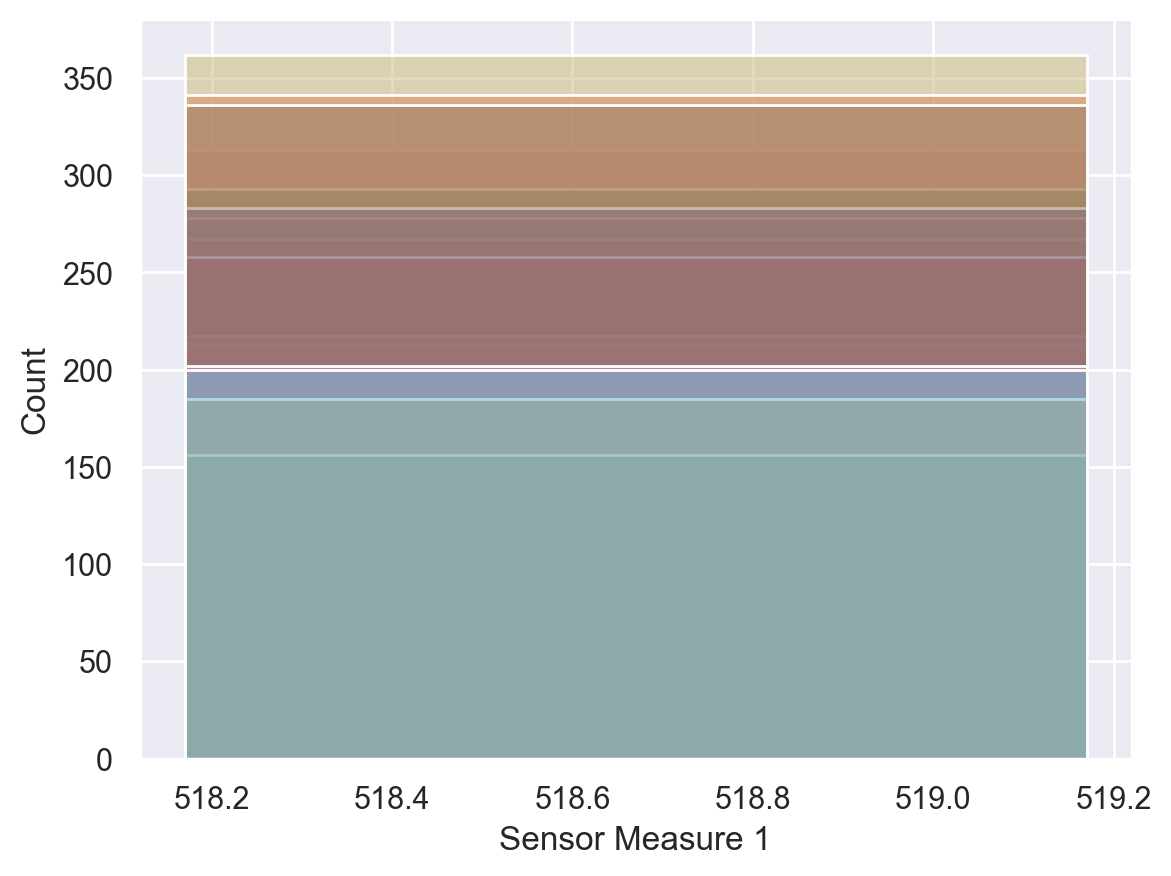

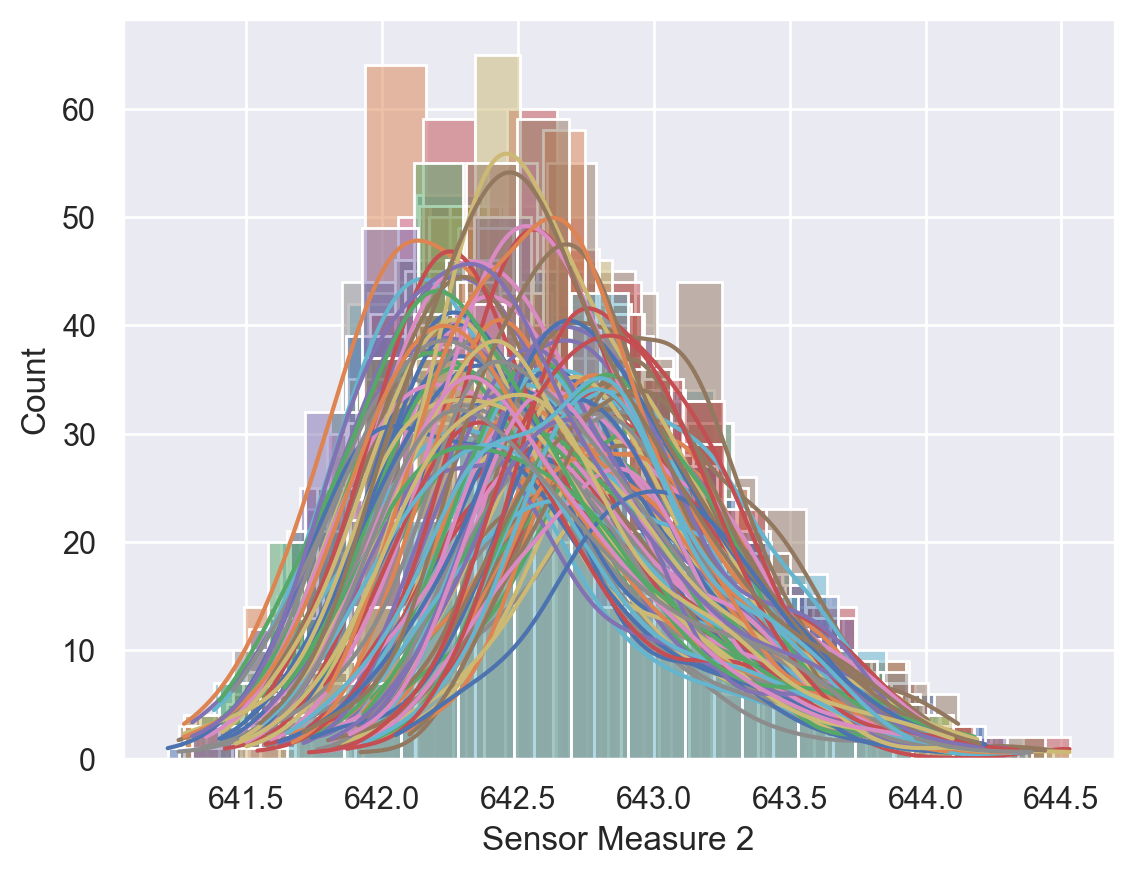

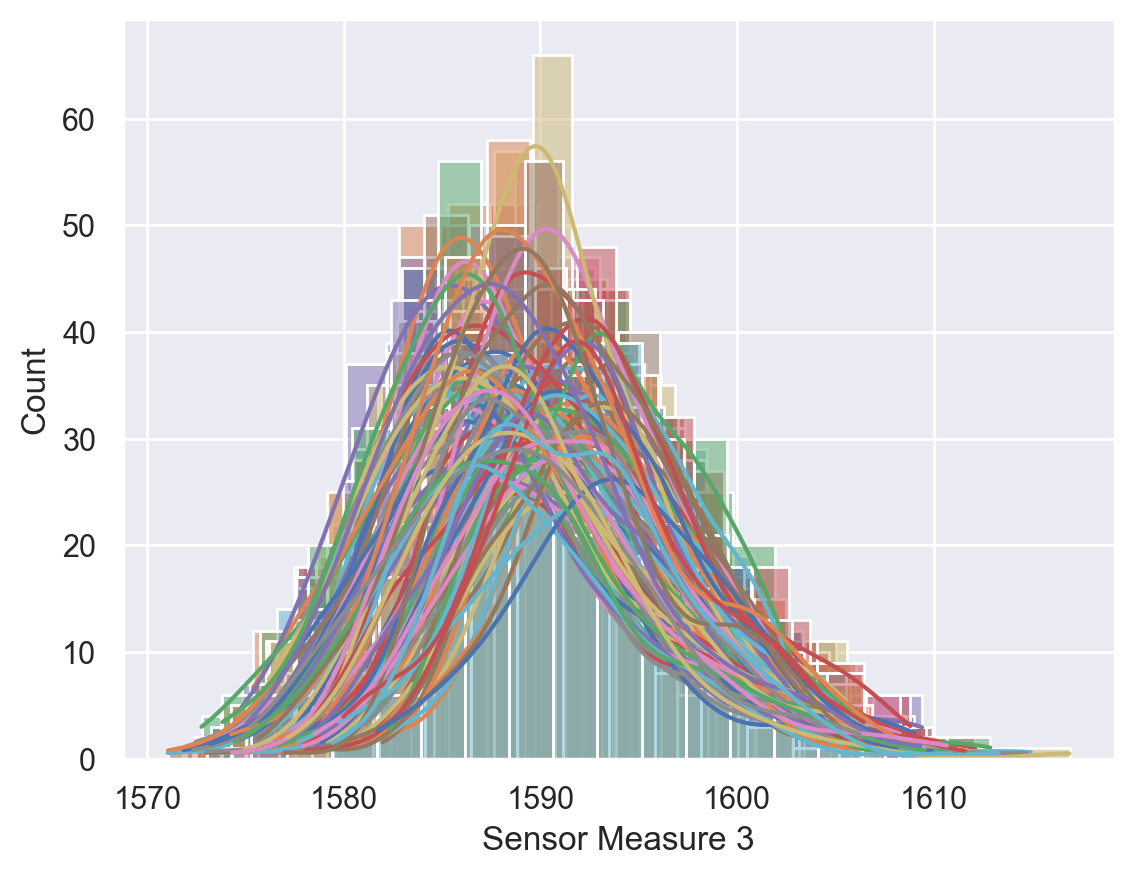

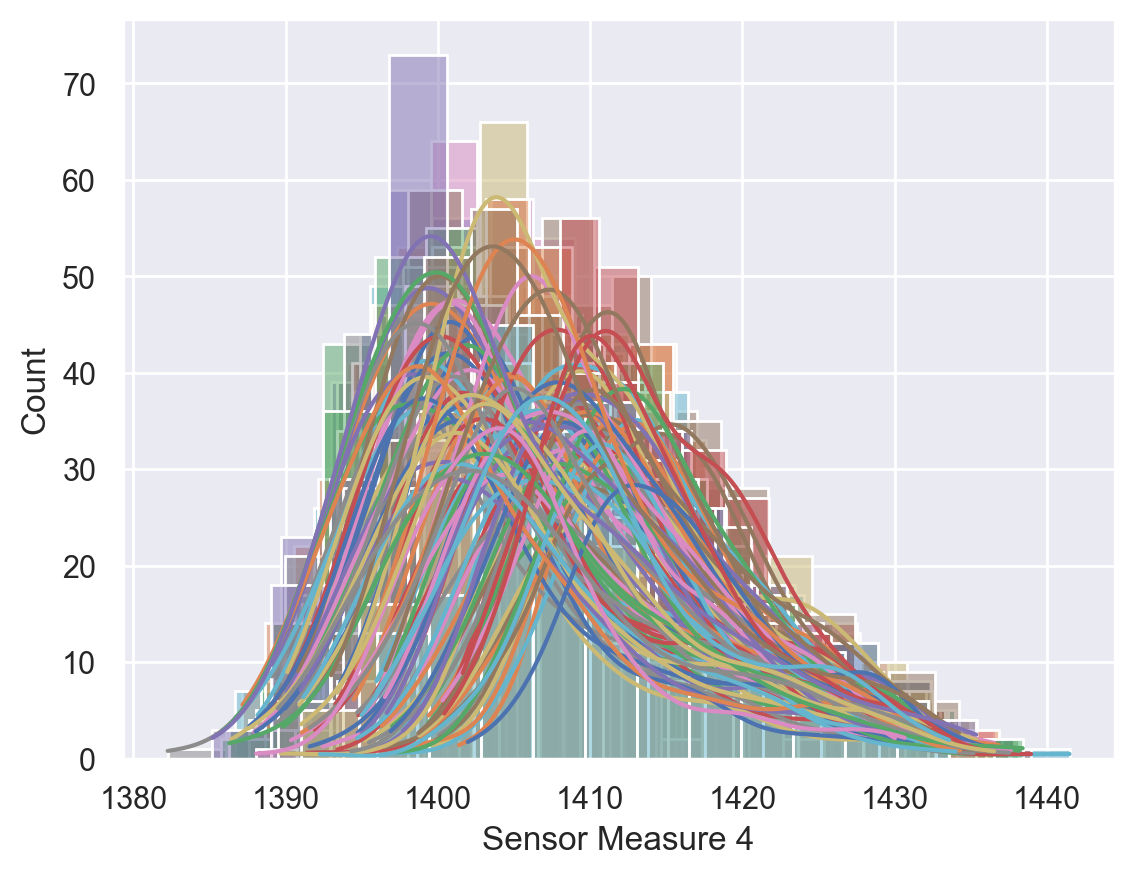

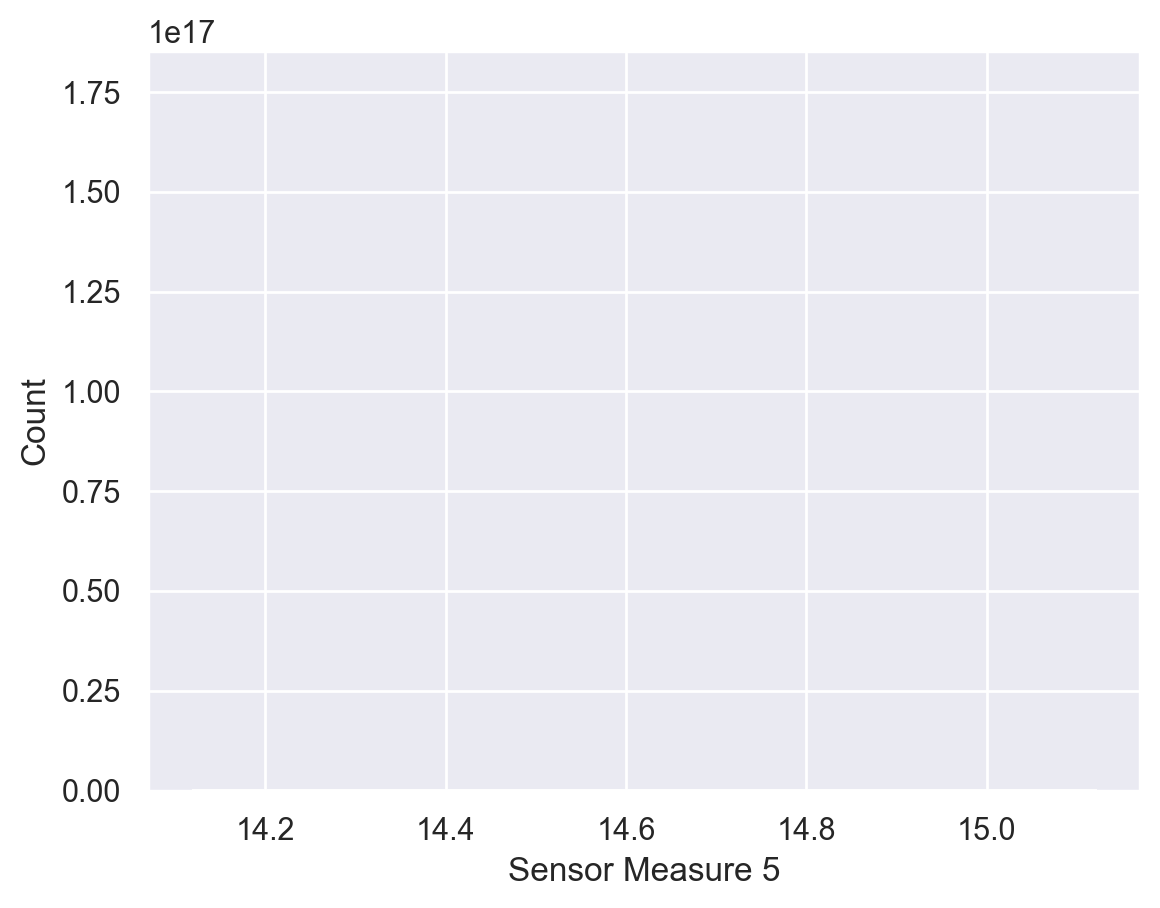

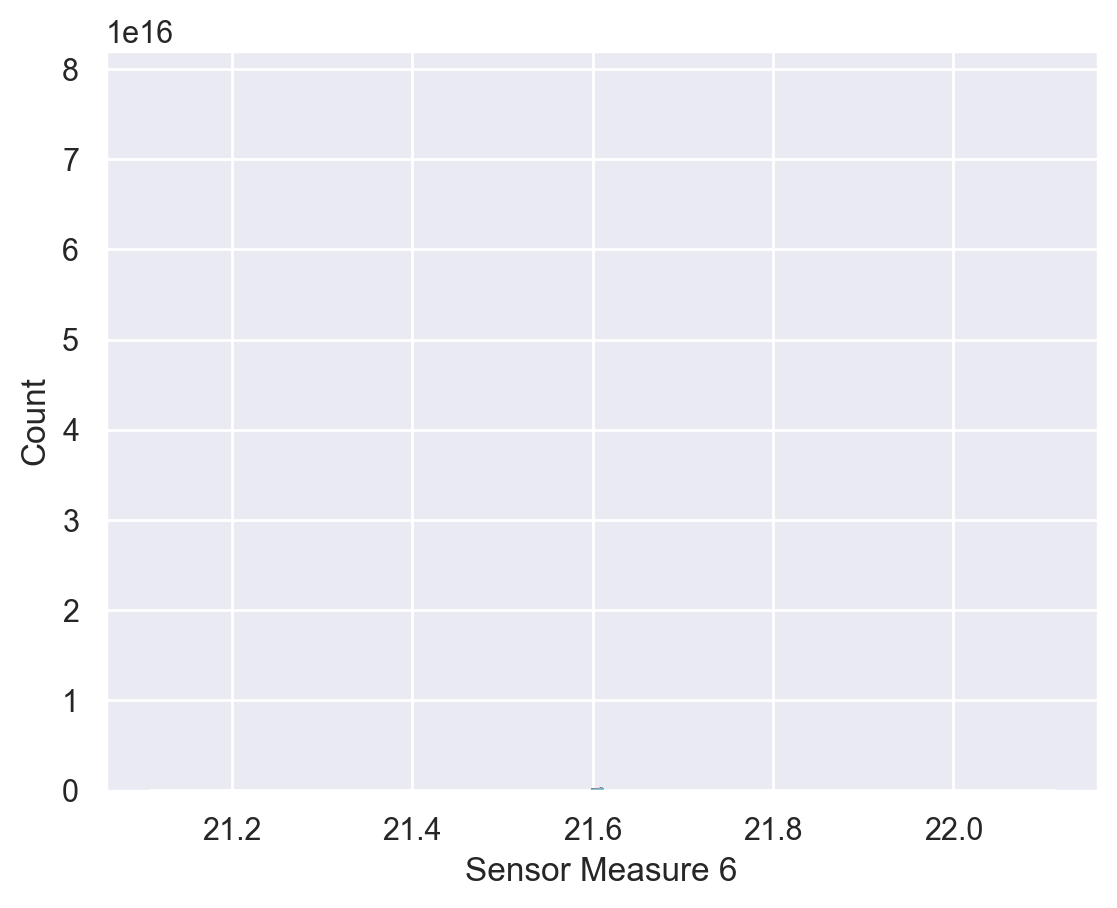

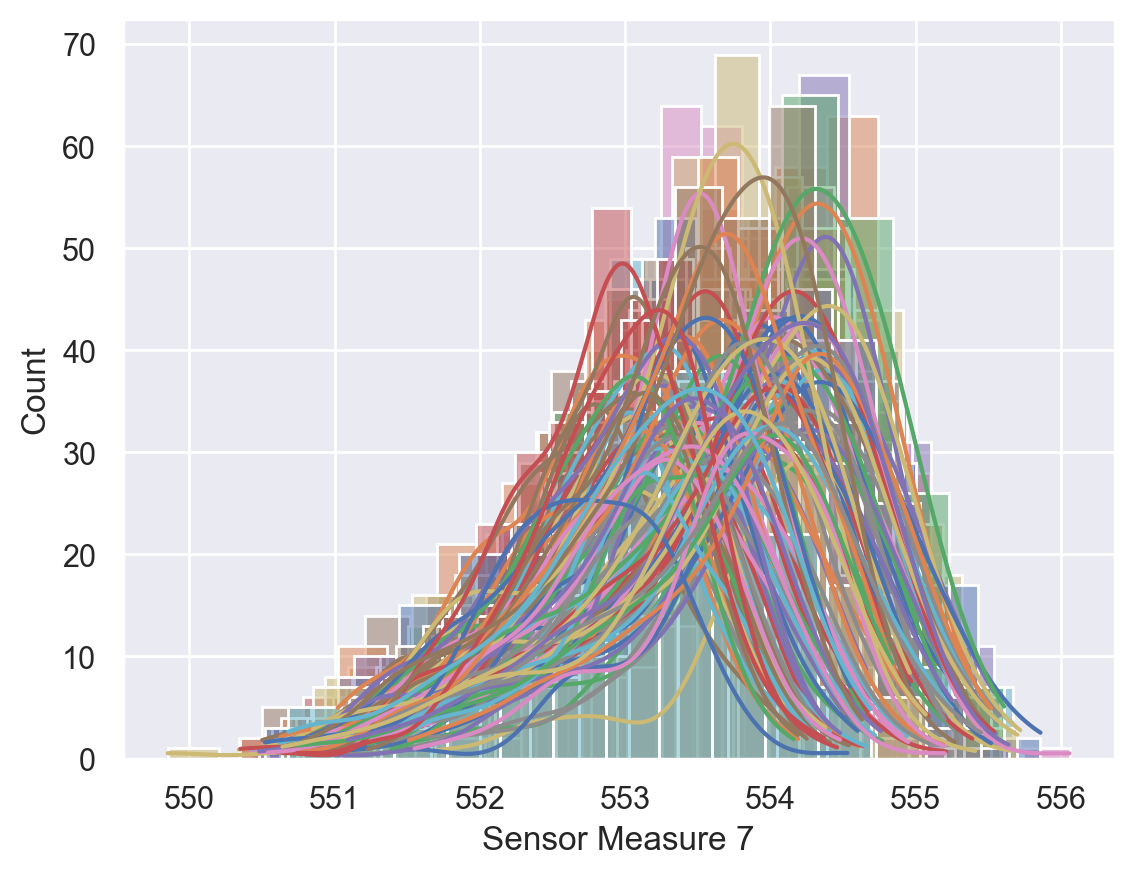

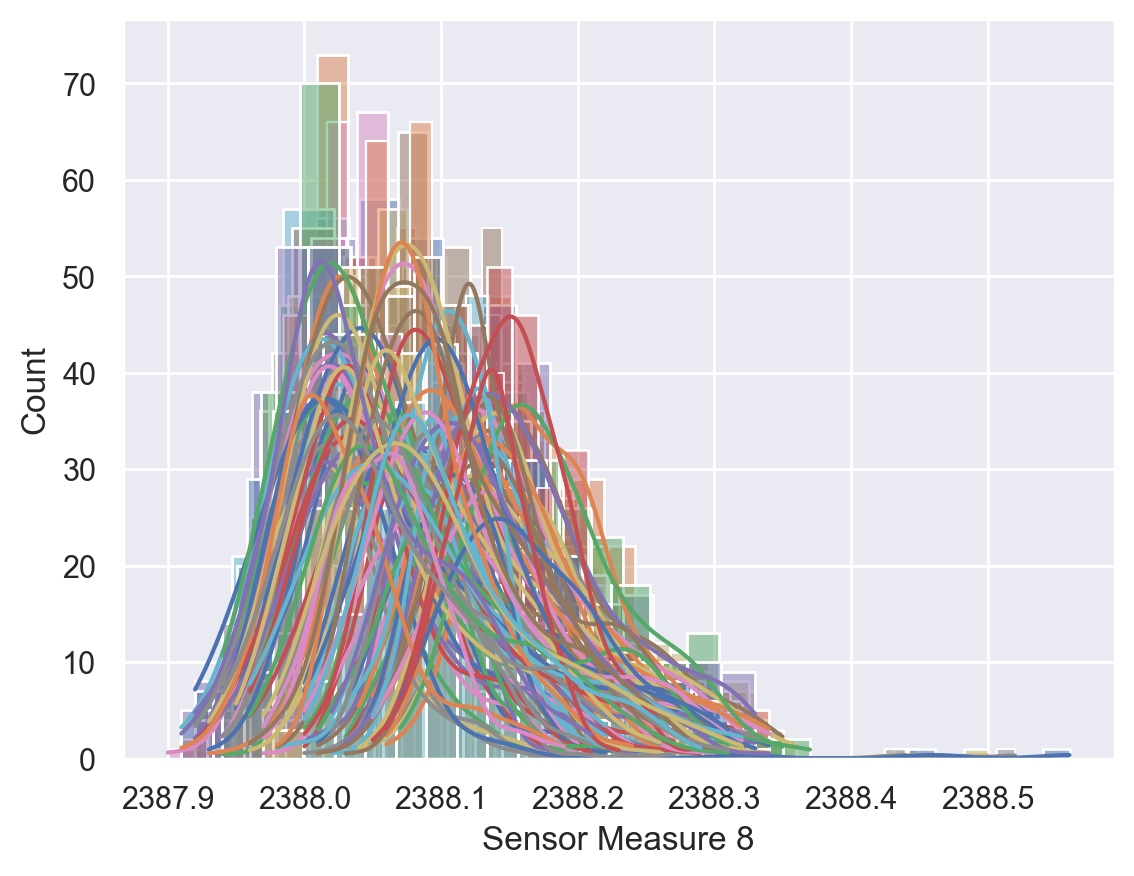

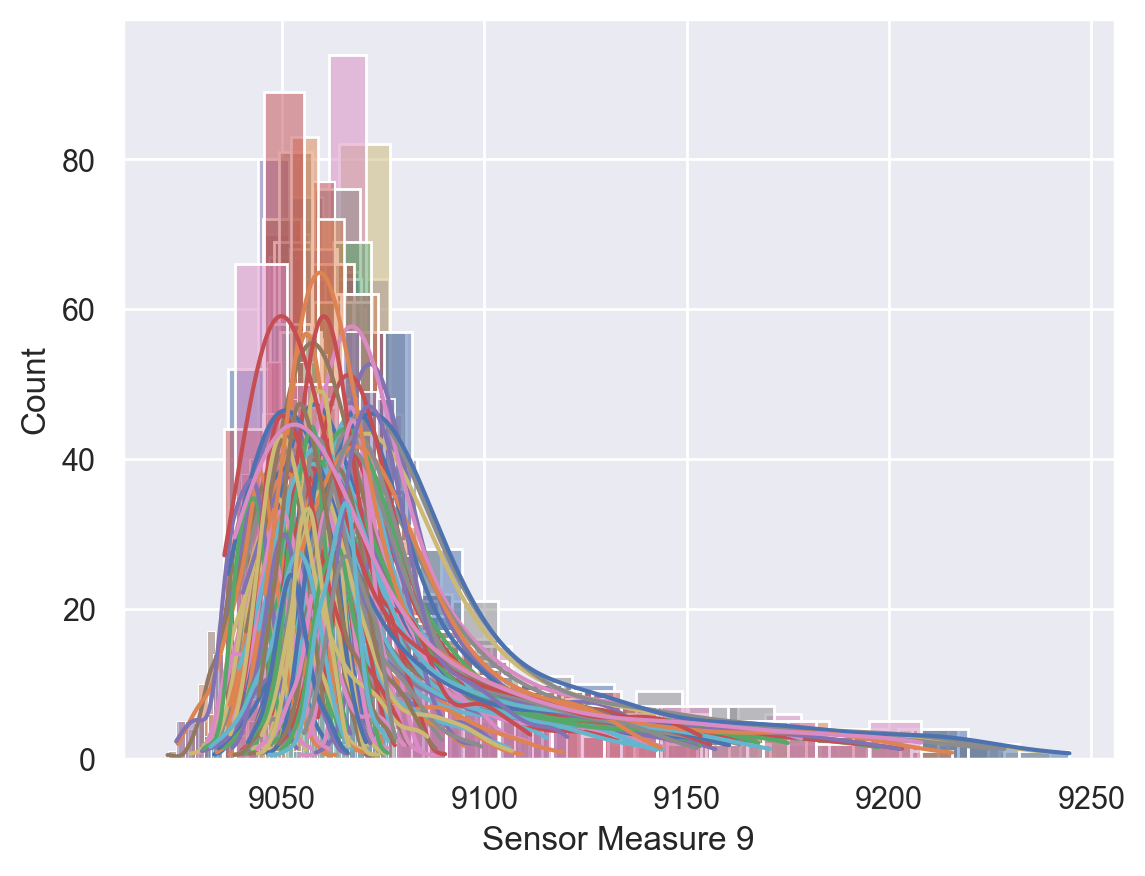

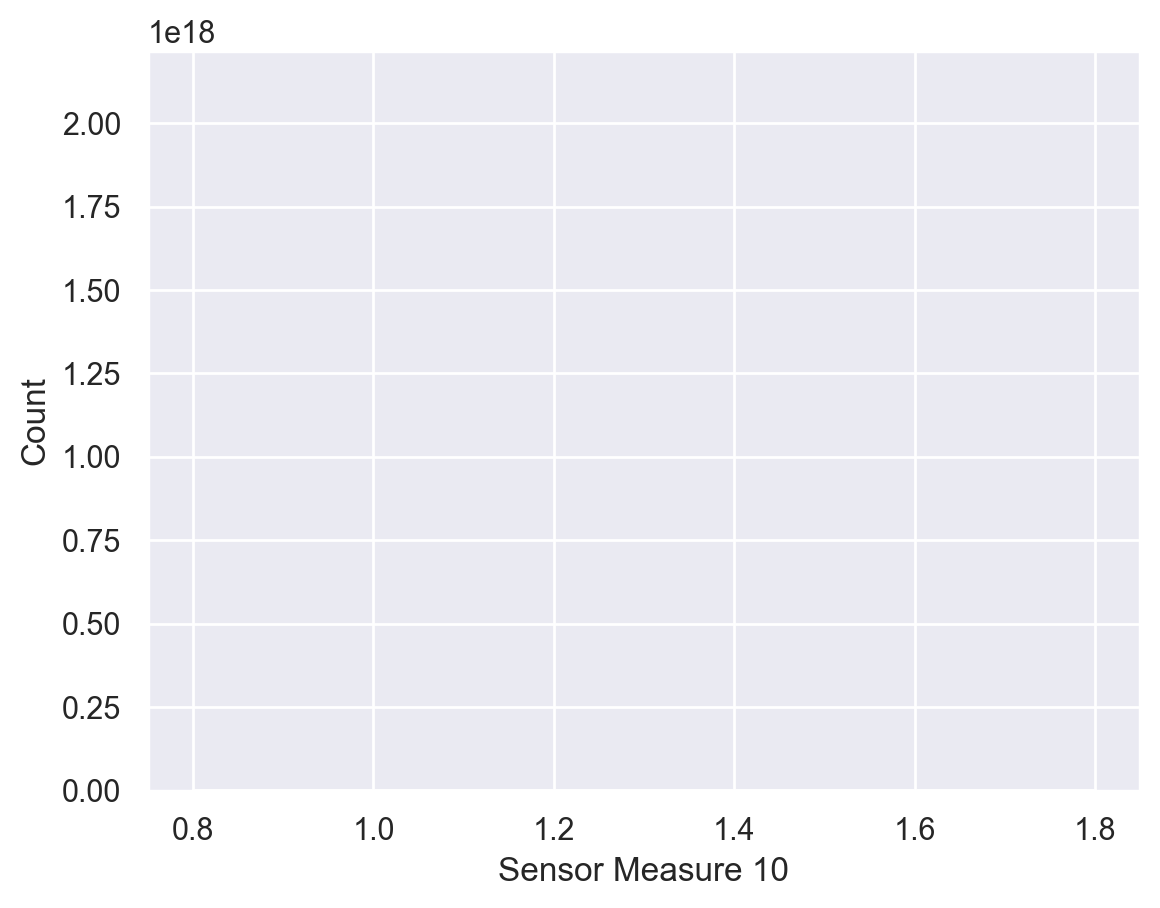

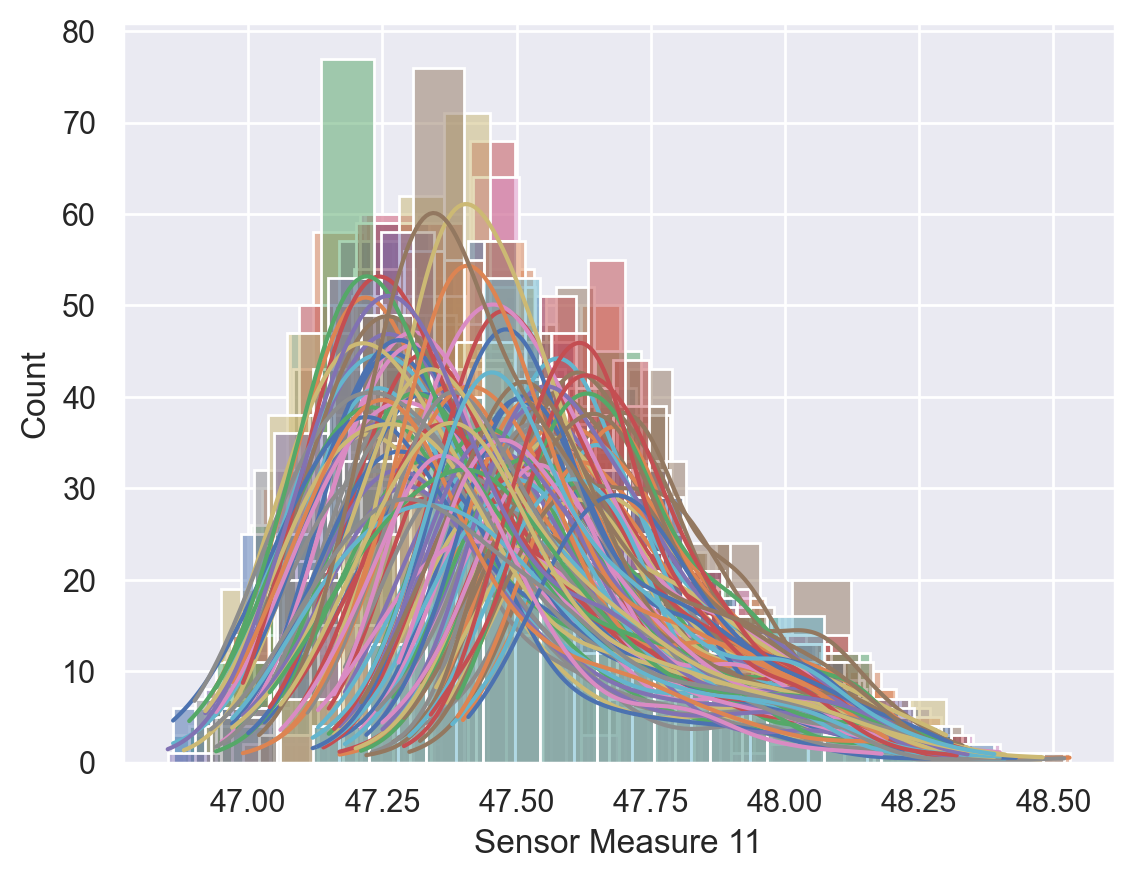

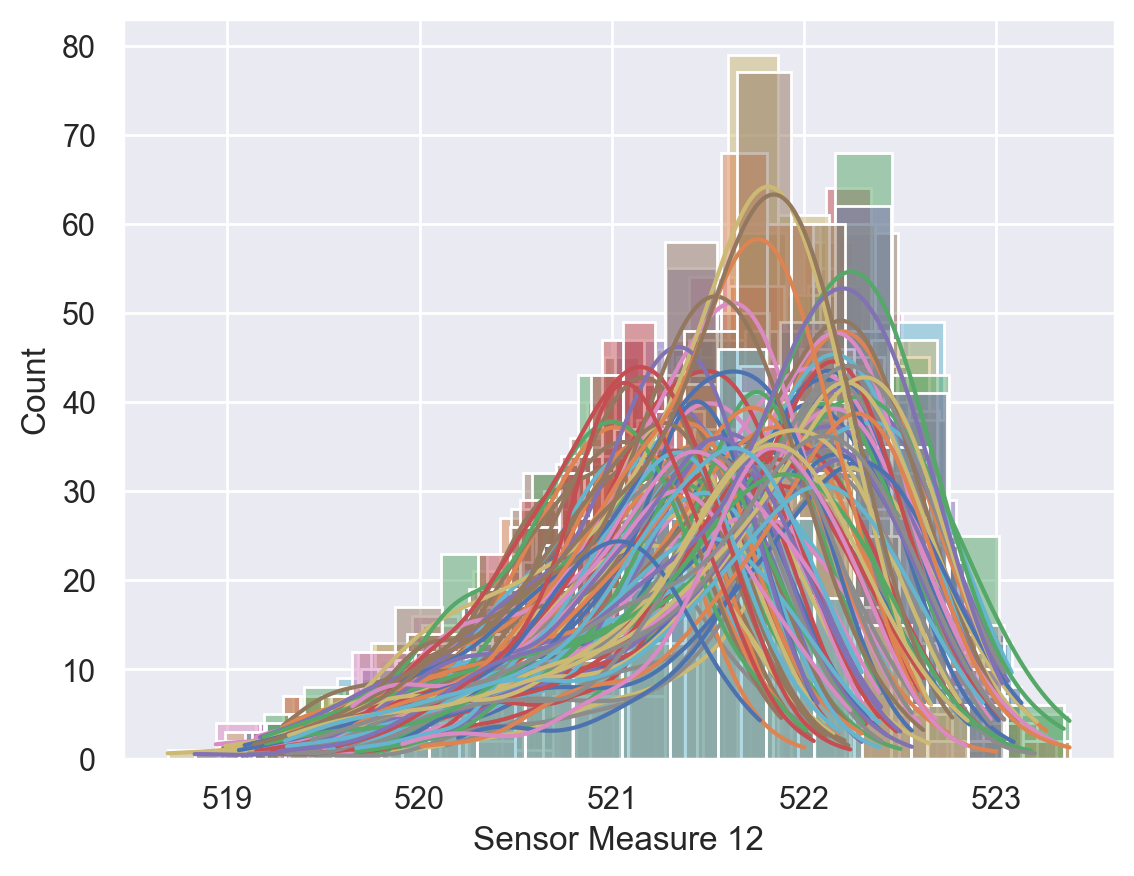

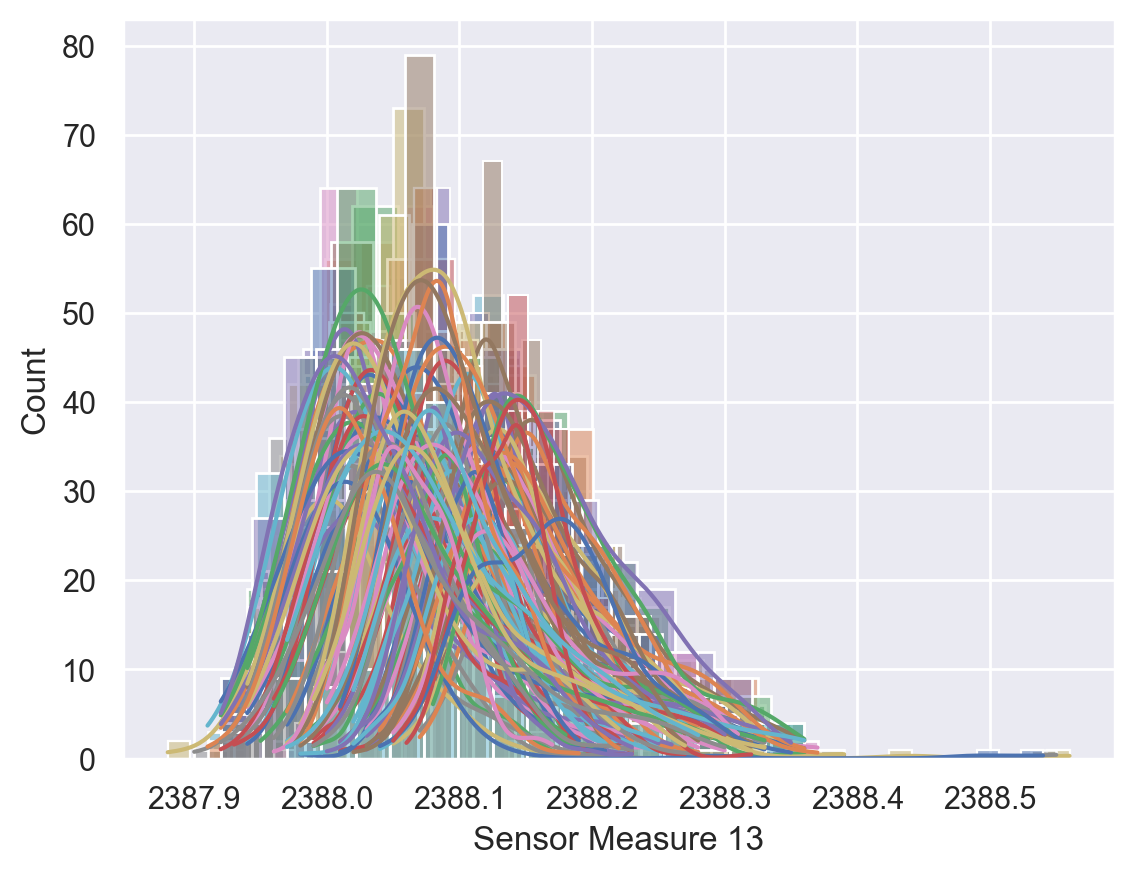

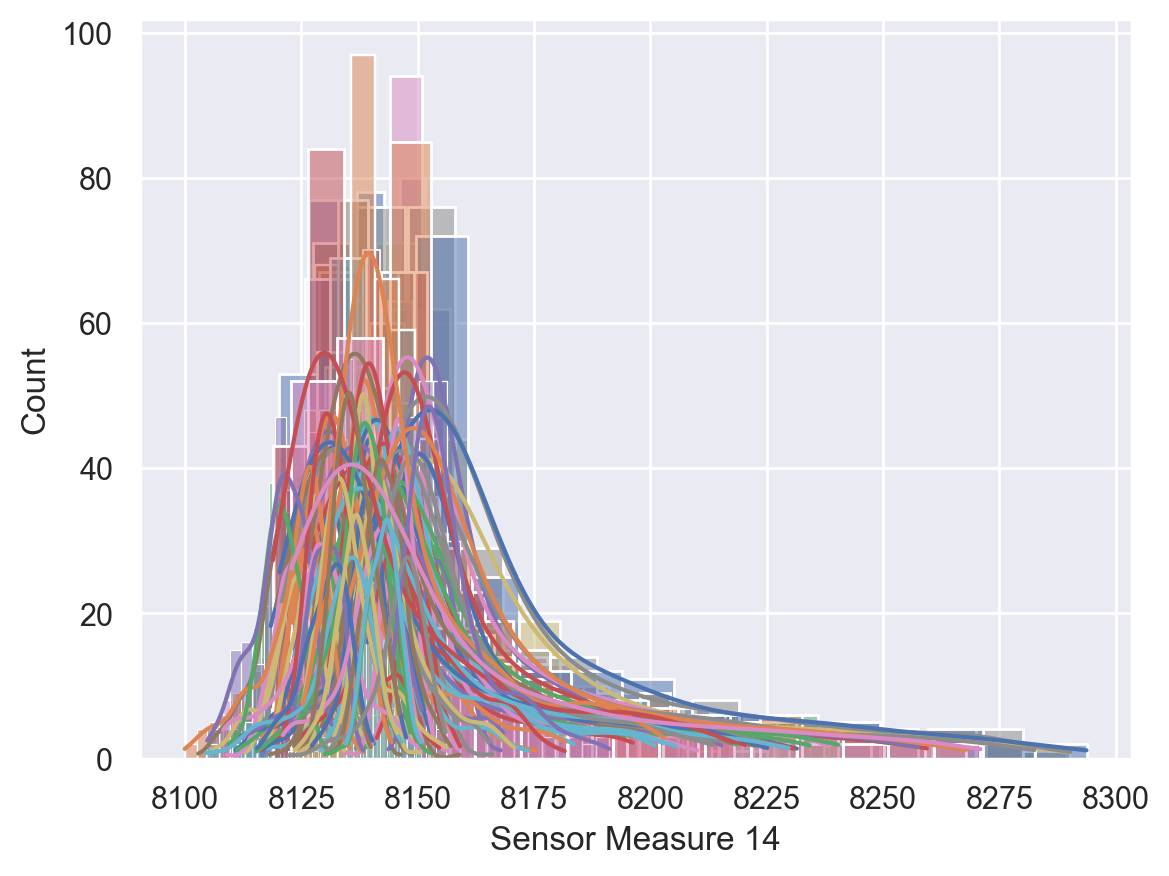

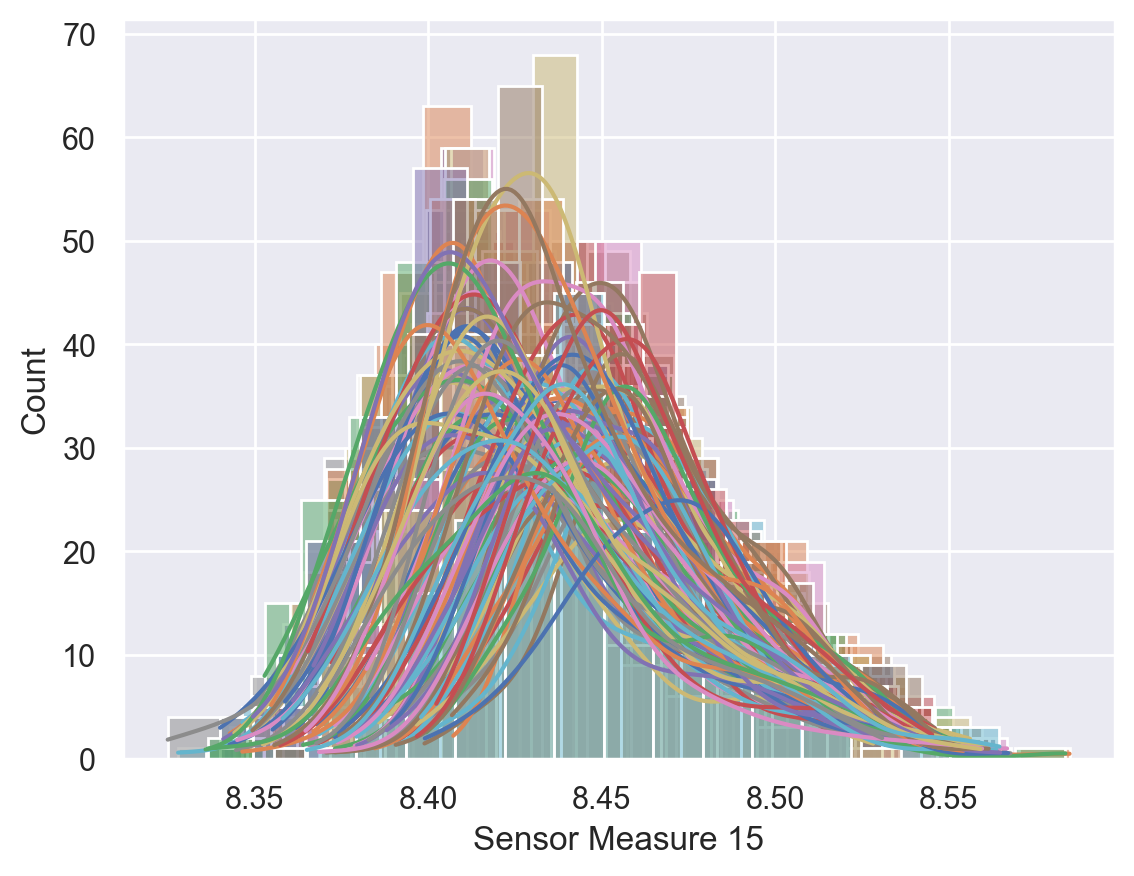

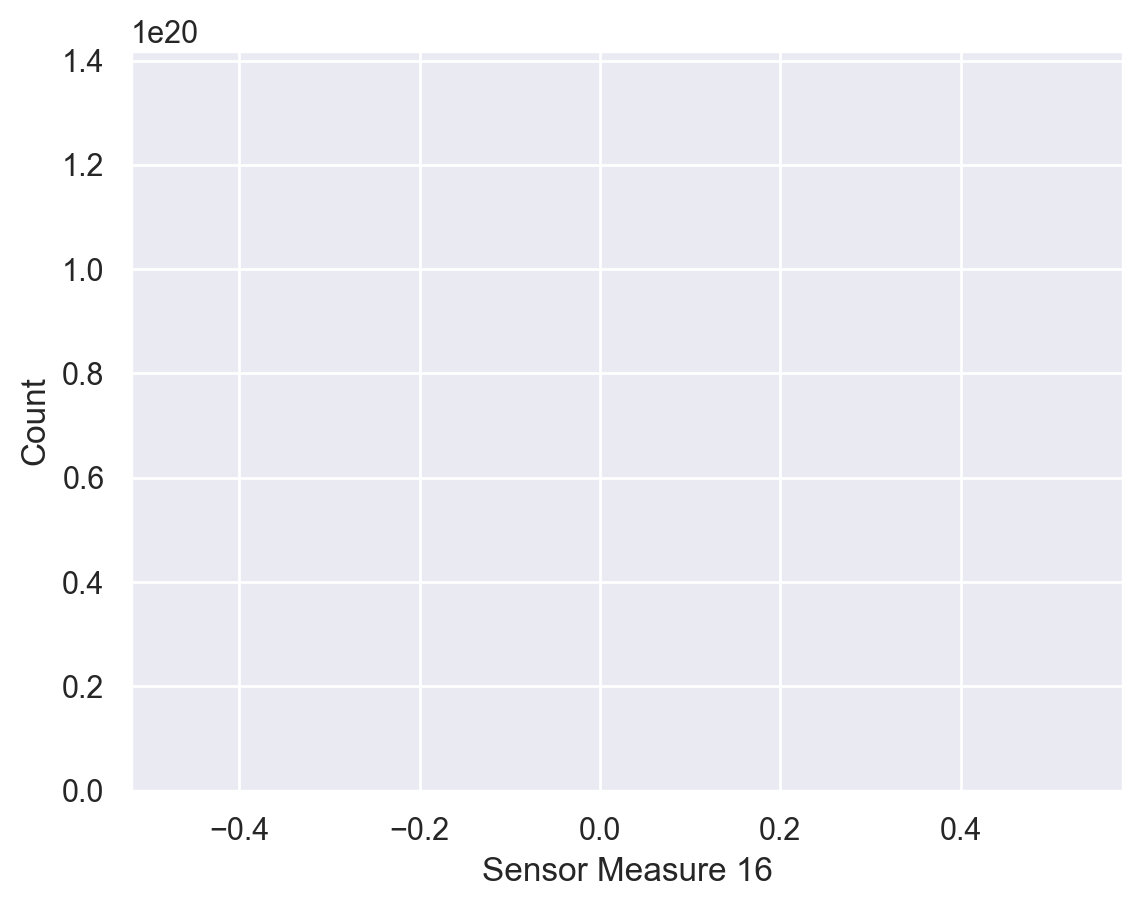

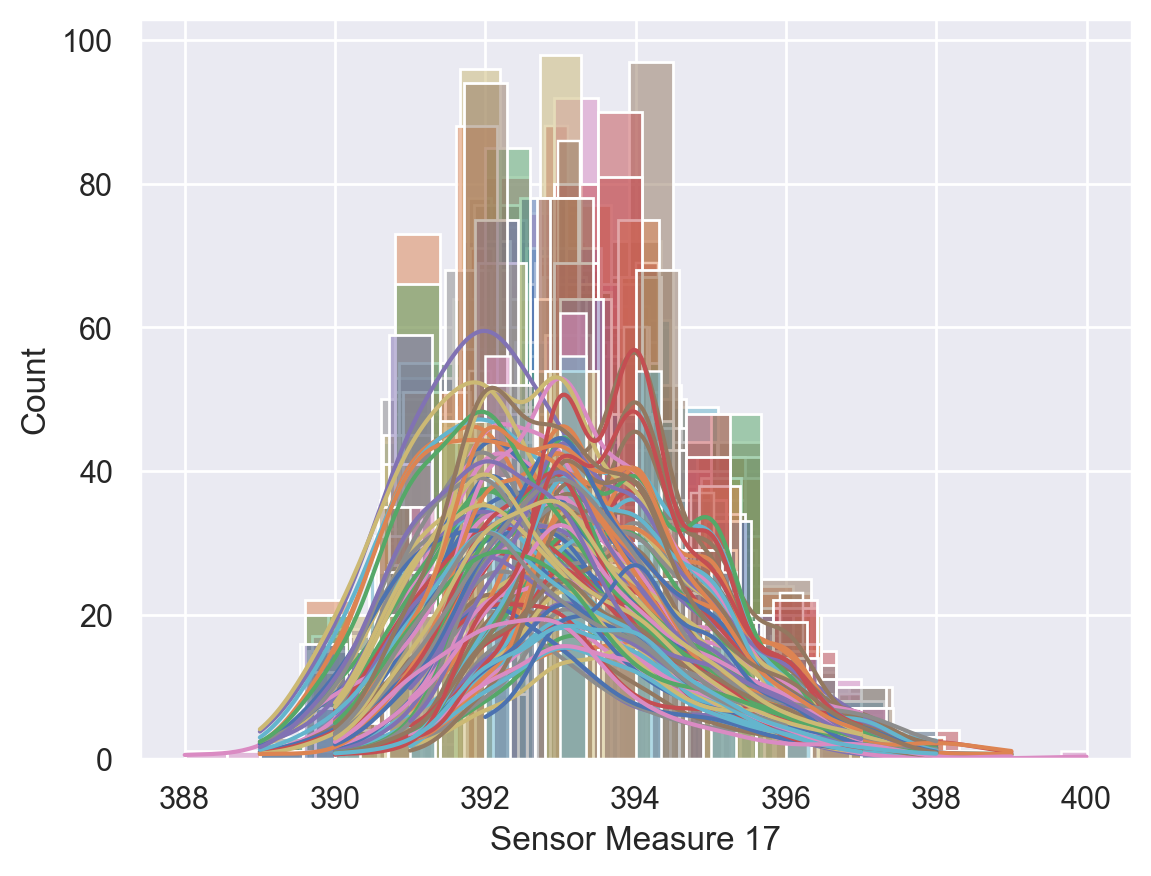

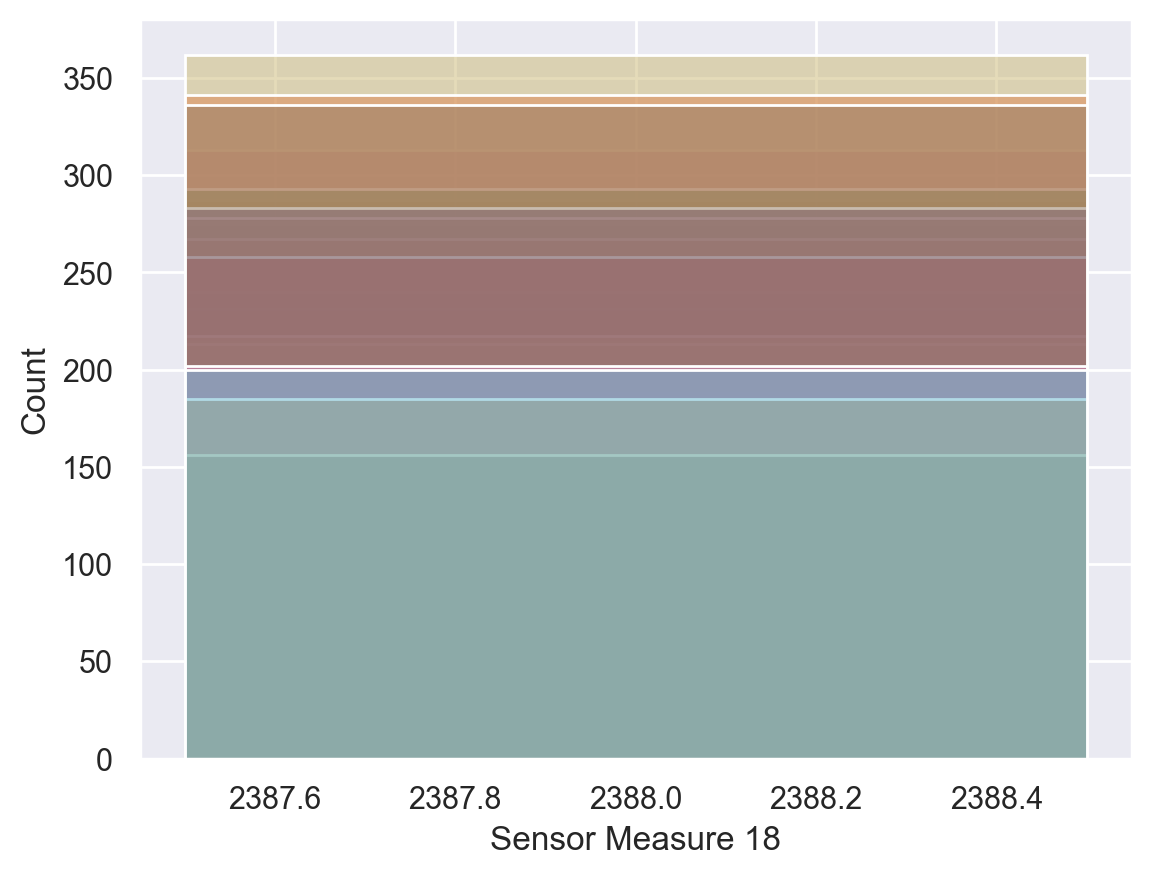

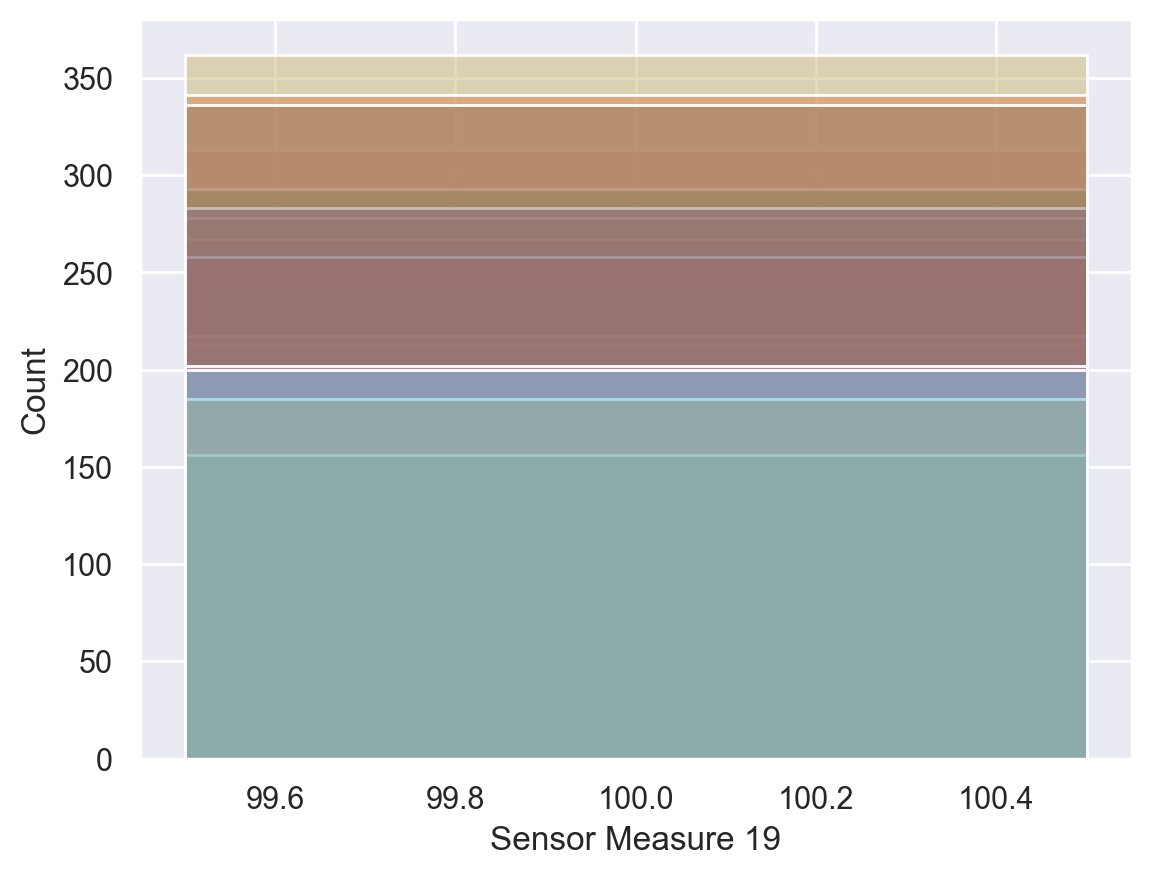

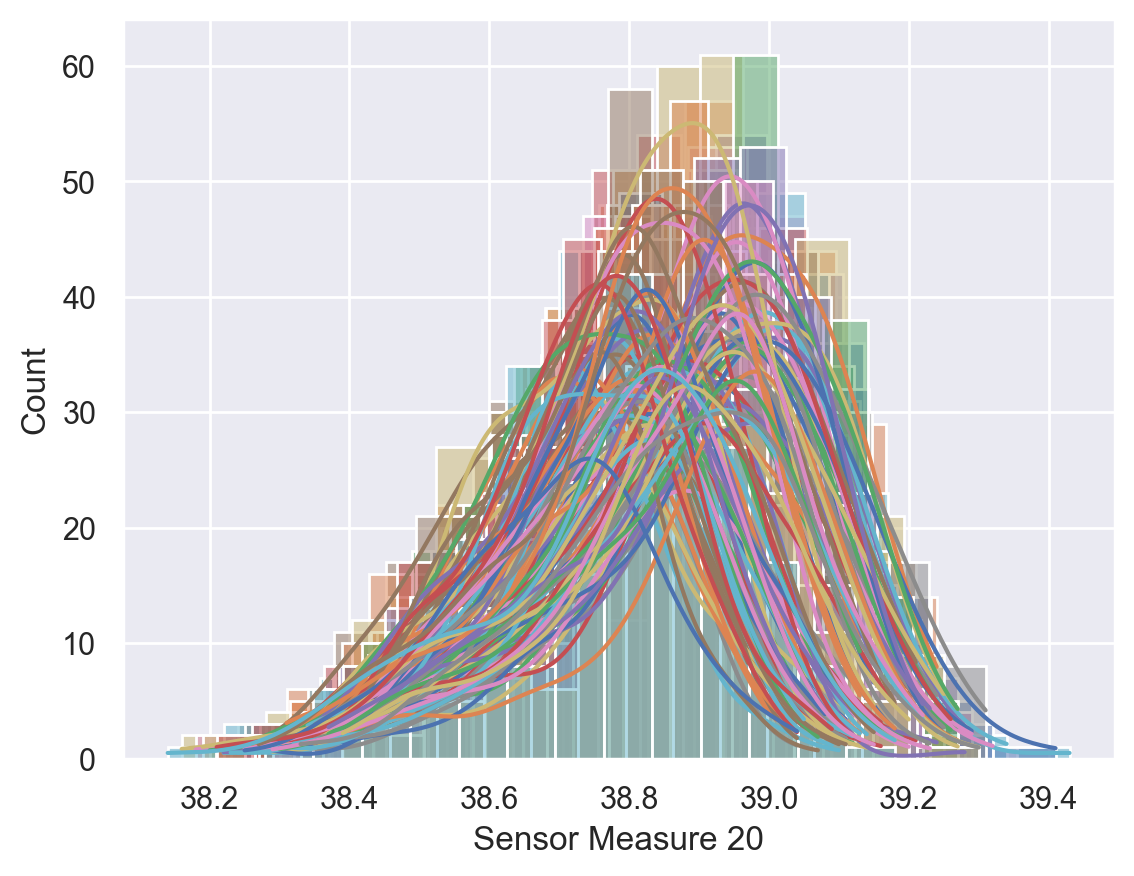

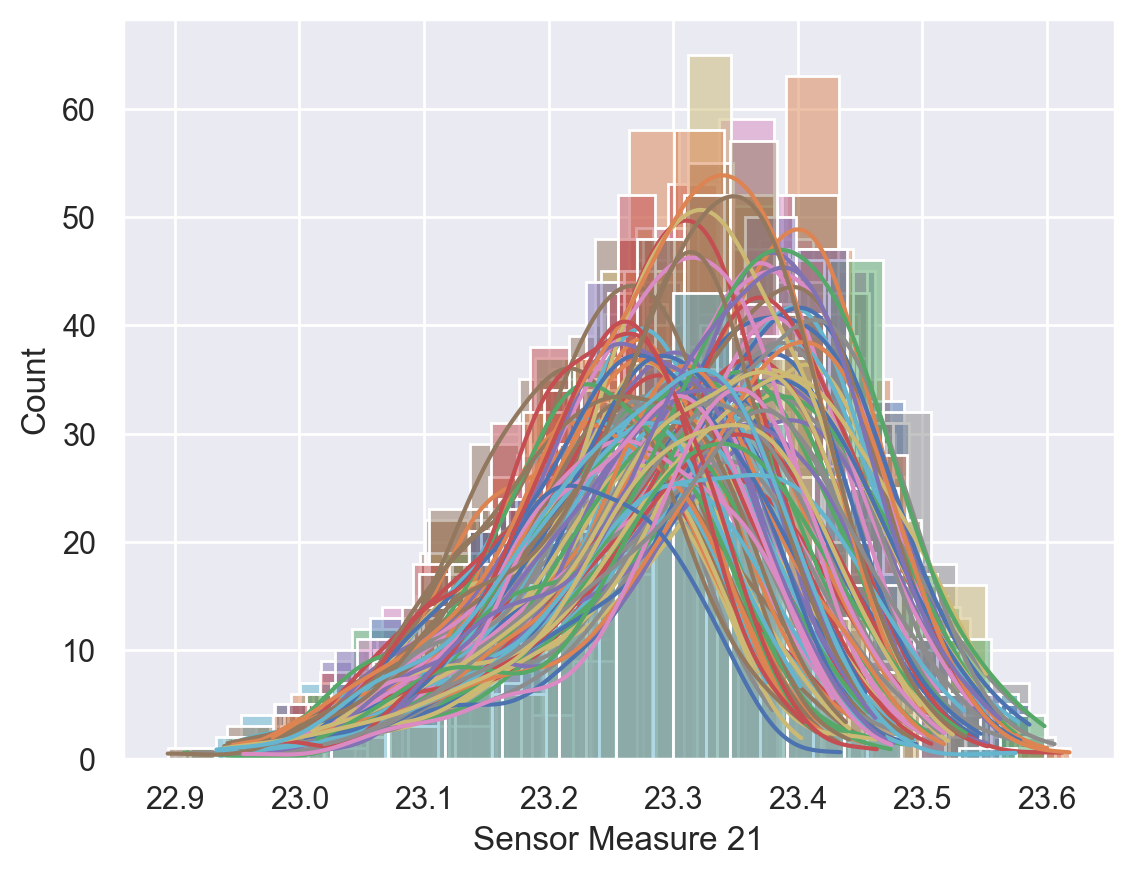

In [237]:
#comparative plots for a single sensor 
for j,col in enumerate(sensor_measure_columns_names):
    for i in range(min_id-1, max_id):
        sns.histplot(data=list_of_dfs[i][col],kde=True,common_norm=False)
    plt.show()

In [229]:
#Temp df without const sensors 
df_features = pd.DataFrame(list_of_dfs[0], copy=True)
target = df_features["RUL"]
df_features = df_features.drop(['UnitNumber','Cycle','Operation Setting 1','Operation Setting 2','Operation Setting 3','Sensor Measure 1', 'Sensor Measure 5', 'Sensor Measure 6','Sensor Measure 10', 'Sensor Measure 16','Sensor Measure 18','Sensor Measure 19'], axis = 1)
#

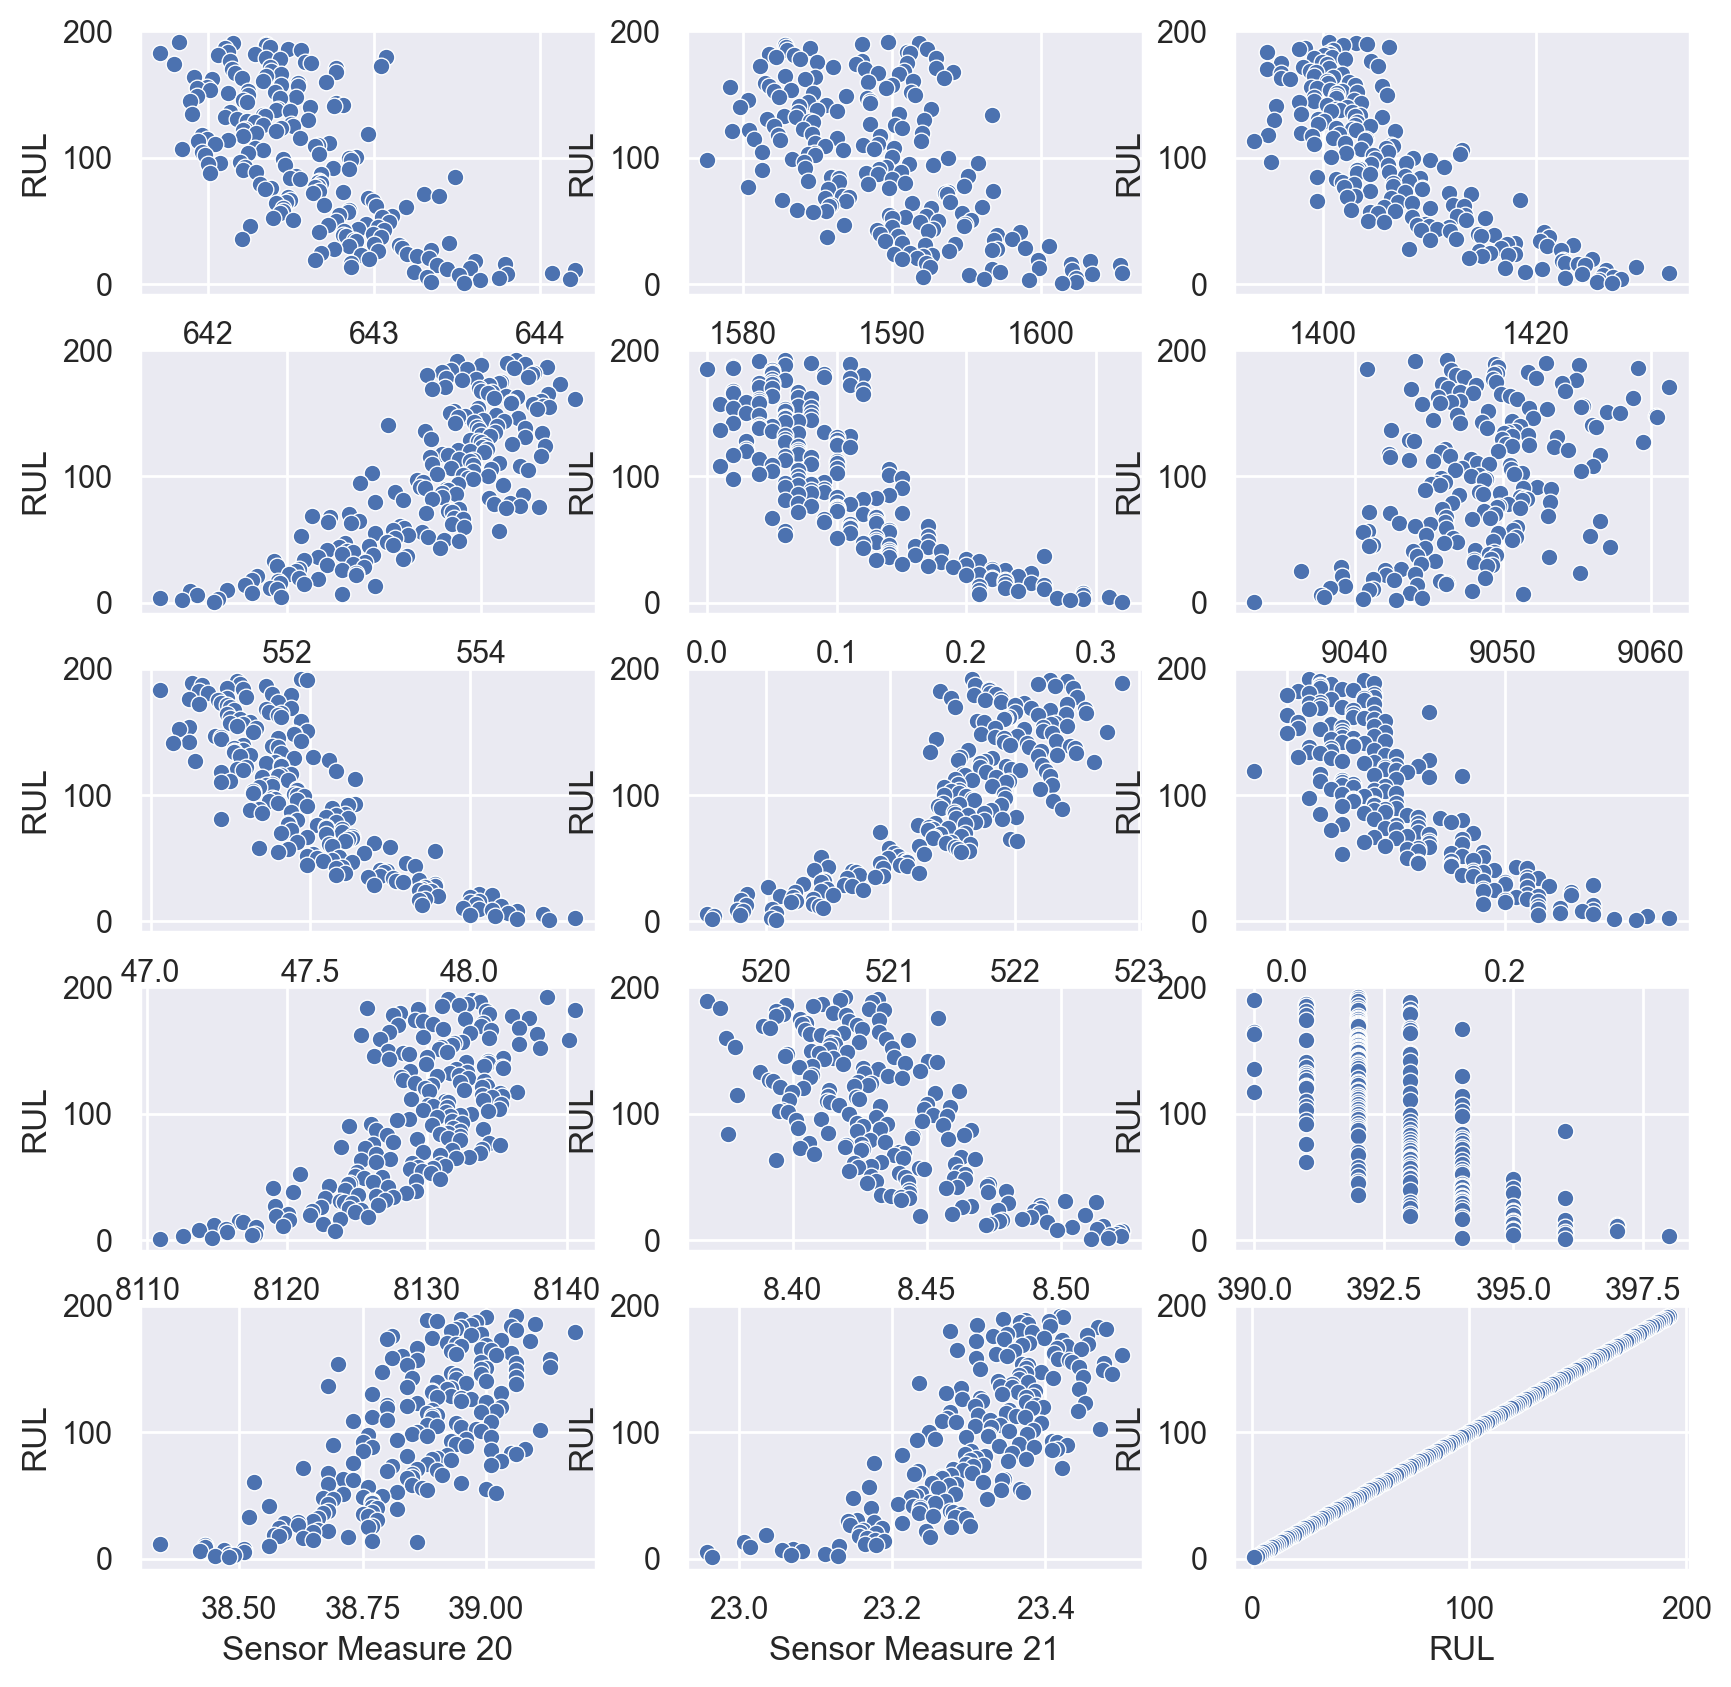

In [235]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (10,10))
for i,col in enumerate(df_features.columns):
    #sns.lineplot(data=df_features,x=col,y=target, ax=ax[i // 3,i % 3])
    sns.scatterplot(data=df_features[:],x=col,y=target, ax=ax[i // 3,i % 3])
plt.show()

<Axes: >

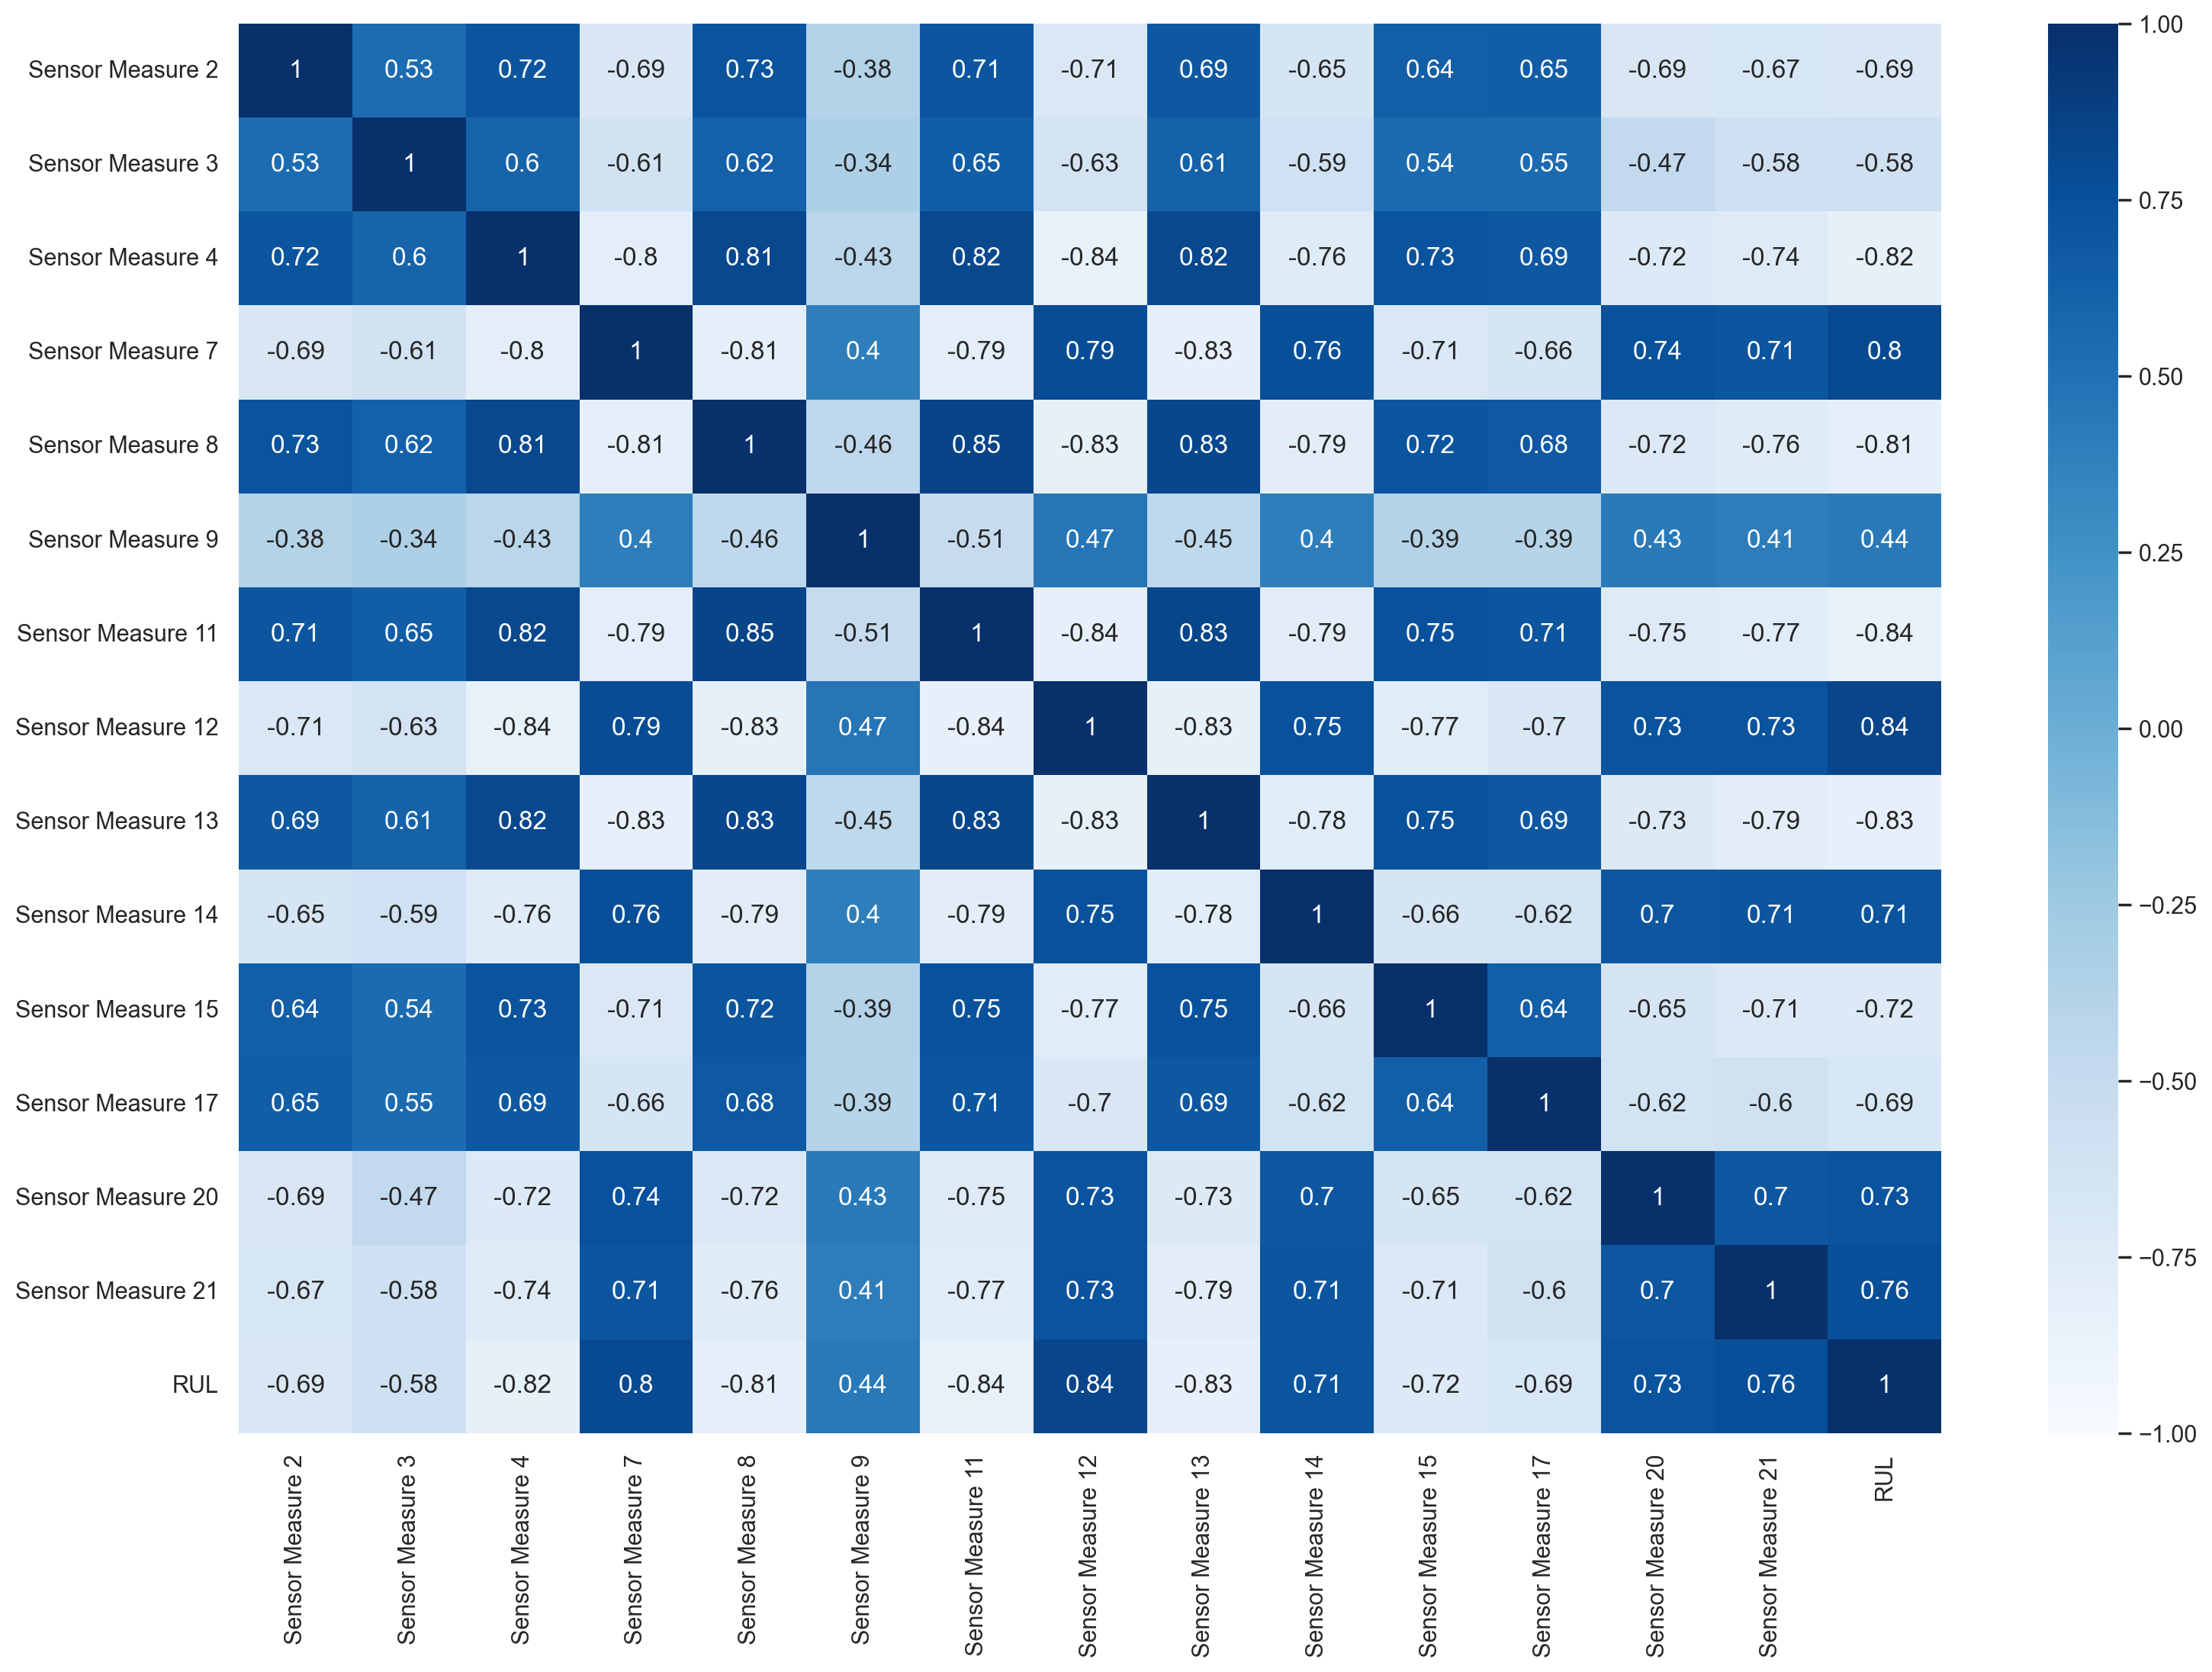

In [236]:
correlation = df_features.corr()

fig = plt.figure(figsize = (18,12))
sns.heatmap(correlation, annot=True,vmin=-1, vmax=1, cmap="Blues")#cmap="coolwarm"

In [46]:
df_allfeatures = pd.read_pickle('C:/Users/c-beh/Documents/KIT/Semester 3/PSDA/Ex2/jb_data/ex2_train_data_3_max_20_min_5_sample_10_20240516-075646.pkl')


In [22]:
def identify_single_unique_features(df: pd.DataFrame, drop: bool = False):
    """
    Identify features with only a single unique value.
    :param df: DataFrame with features to investigate.
    :param drop: Boolean to indicate whether to drop the features from the DataFrame.
    :return: DataFrame or list
    """
    single_unique_features = [col for col in df.columns if df[col].nunique(dropna=True) == 1]

    print(f"Found {len(single_unique_features)} features with only a single unique value.")

    if drop:
        df.drop(columns=single_unique_features, inplace=True)
        return df
    else:
        return single_unique_features

In [37]:
df_test = df_allfeatures.copy()
identify_single_unique_features(df_test, drop=True)


len(set(df_allfeatures.columns) ^ set(df_test.columns))

Found 11595 features with only a single unique value.


11595

In [51]:
df_allfeatures["UnitNumber"]

KeyError: 'UnitNumber'

In [11]:

for i in range(0,1000):
    print(df_allfeatures.columns[i])
#df_allfeatures

Operation Setting 1__variance_larger_than_standard_deviation
Operation Setting 1__has_duplicate_max
Operation Setting 1__has_duplicate_min
Operation Setting 1__has_duplicate
Operation Setting 1__sum_values
Operation Setting 1__abs_energy
Operation Setting 1__mean_abs_change
Operation Setting 1__mean_change
Operation Setting 1__mean_second_derivative_central
Operation Setting 1__median
Operation Setting 1__mean
Operation Setting 1__length
Operation Setting 1__standard_deviation
Operation Setting 1__variation_coefficient
Operation Setting 1__variance
Operation Setting 1__skewness
Operation Setting 1__kurtosis
Operation Setting 1__root_mean_square
Operation Setting 1__absolute_sum_of_changes
Operation Setting 1__longest_strike_below_mean
Operation Setting 1__longest_strike_above_mean
Operation Setting 1__count_above_mean
Operation Setting 1__count_below_mean
Operation Setting 1__last_location_of_maximum
Operation Setting 1__first_location_of_maximum
Operation Setting 1__last_location_of_m